# Projet Python : Prédiction du nombre d'étoiles d'un restaurant français

### Mohamed SAFFAR - Axel NAOARINE

In [ ]:
#! pip install geopandas
#! apt install libspatialindex-dev
#! pip install "rtree>=0.8,<0.9"

In [1]:
import numpy as np
import os
import urllib
import re
import bs4
import pandas as pd
import datetime
import requests
import tempfile
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# Création des bases de données

## ----------------------------------------------------------------------------------------------------------------------------------

## Récupération des informations des chefs des restaurants 2* et 3* sur WIKIPEDIA

In [2]:
# Etape 1 : se connecter à la page wikipedia et obtenir le code source
from urllib import request
from urllib.parse import quote

url_wiki_resto = 'https://fr.wikipedia.org/wiki/' + quote('Liste_des_restaurants_deux_et_trois_étoiles_du_Guide_Michelin')
    

request_text = request.urlopen(url_wiki_resto).read()

In [3]:
# Etape 2 : utiliser le package BeautifulSoup

page = bs4.BeautifulSoup(request_text, "lxml")

### Récupération table des restaurants 3*

In [4]:
# on identifie le tableau en question 
tableau_resto_3 = page.findAll('table', {'class' : 'wikitable sortable'})[2]

In [5]:
table_body = tableau_resto_3.find('tbody')

# on recherche toutes les lignes du tableau avec la balise "tr"
rows = table_body.find_all('tr')
dico_resto_3 = dict()
i=-1
for row in rows:
    i=i+1
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols[:-1]]
    if len(cols) > 0 : 
        dico_resto_3[str(i)] = cols
data_resto_3 = pd.DataFrame.from_dict(dico_resto_3,orient='index')

In [6]:
#On recupere les noms des colonnes
for row in rows:
    cols = row.find_all('th')
    if len(cols) > 0 : 
        cols = [ele.get_text(separator=' ').strip().title() for ele in cols[:-1]]
        columns_resto3 = cols
data_resto_3.columns = columns_resto3

In [7]:
data_resto_3.head(10)

,Année,Chef,Établissement,Localité,Département,Région
1,1968,Michel Troisgros,Le Bois sans Feuilles,Ouches,42 Loire,Auvergne-Rhône-Alpes
2,1977,Michel Guérard,Les Prés d'Eugénie,Eugénie-les-Bains,40 Landes,Nouvelle-Aquitaine
3,1981,Georges Blanc,Georges Blanc,Vonnas,01 Ain,Auvergne-Rhône-Alpes
4,1986,Bernard Pacaud,L'Ambroisie,Paris 4e,75 Paris,Île-de-France
5,1993,Pierre Gagnaire,Pierre Gagnaire,Paris 8e,75 Paris,Île-de-France
6,1996,Alain Passard,L'Arpège,Paris 7e,75 Paris,Île-de-France
7,2002,Guy Savoy,Guy Savoy,Paris 6e,75 Paris,Île-de-France
8,2003,Alain Ducasse,Le Louis XV - Alain Ducasse,Monte-Carlo,,Monaco
9,2005,Régis Marcon,Régis et Jacques Marcon,Saint-Bonnet-le-Froid,43 Haute-Loire,Auvergne-Rhône-Alpes
10,2007,Frédéric Anton,Le Pré Catelan,Paris 16e,75 Paris,Île-de-France


### On enrichie la table avec des informations sur les chefs 3*

In [8]:
nom=[]
naissance=[]
nationalité=[]
distinction=[]
for row in rows:
    info = row.find_all('td')
    print(info)
    if len(info) > 0 : 
            if info[1].find('a')!=None :
                chef_url=info[1].find('a').get('href')
                name_chef=info[1].find('a').text
                nom.append(name_chef)
                url_get_info = "http://fr.wikipedia.org"+chef_url
                print(url_get_info)

                # aller sur la page du chef

                search = urllib.request.urlopen(url_get_info).read()
                search_chef=bs4.BeautifulSoup(search)

                info_chef=search_chef.find('table')
                table_body2 = info_chef.find('tbody')

                # on recherche toutes les lignes du tableau avec la balise "tr"
                rows2 = table_body2.find_all('tr')
                # on obtient une liste où chaque élément est une des lignes du tableau
                liste=['Naissance','Nationalité','Distinctions']
                for type_info in liste :
                    i=0
                    try:
                        while rows2[i].find_all('th')[0].text != type_info:
                            i=i+1
                        row2=rows2[i].find_all('td')

                        if type_info == 'Naissance':
                            naissance.append(row2[0].find('time')['datetime'])
                        elif type_info == 'Nationalité':
                            nation=None
                            i=0
                            while nation==None:
                                nat=row2[0].find_all('a')[i].text
                                if nat != '':
                                    nation=nat
                                i=i+1
                            nationalité.append(nation)
                        else:
                            dist_chef=[]
                            for ele in row2[0].find_all('a'):
                                dist_chef.append(ele.text)
                            distinction.append(dist_chef)
                    except:
                        if type_info == 'Naissance':
                            naissance.append(None)
                        elif type_info == 'Nationalité':
                            nationalité.append(None)
                        else:
                            distinction.append(None)

[]
[<td><a href="/wiki/1968" title="1968">1968</a></td>, <td><a href="/wiki/Troisgros" title="Troisgros">Michel Troisgros</a></td>, <td><i>Le Bois sans Feuilles</i></td>, <td><a href="/wiki/Ouches" title="Ouches">Ouches</a></td>, <td>42 <a href="/wiki/Loire_(d%C3%A9partement)" title="Loire (département)">Loire</a></td>, <td><a href="/wiki/Auvergne-Rh%C3%B4ne-Alpes" title="Auvergne-Rhône-Alpes">Auvergne-Rhône-Alpes</a></td>, <td>
</td>]
http://fr.wikipedia.org/wiki/Troisgros
[<td><a href="/wiki/1977" title="1977">1977</a></td>, <td><a href="/wiki/Michel_Gu%C3%A9rard" title="Michel Guérard">Michel Guérard</a></td>, <td><i>Les Prés d'Eugénie</i></td>, <td><a href="/wiki/Eug%C3%A9nie-les-Bains" title="Eugénie-les-Bains">Eugénie-les-Bains</a></td>, <td>40 <a href="/wiki/Landes_(d%C3%A9partement)" title="Landes (département)">Landes</a></td>, <td><a href="/wiki/Nouvelle-Aquitaine" title="Nouvelle-Aquitaine">Nouvelle-Aquitaine</a></td>, <td>
</td>]
http://fr.wikipedia.org/wiki/Michel_Gu%C3%A9

In [9]:
#petit traitement de la base
distinction[12][0]='3 étoiles au Guide Michelin'
distinction[17][0]='3 étoiles au Guide Michelin'
naissance[0]='1958-04-02'
nationalité[0]='Français'
#petit vérif
print(len(distinction))
print(len(nom))
print(len(nationalité))
print(len(naissance))

27
27
27
27


In [10]:
dicto = {'nom' : nom , 'naissance': naissance, 'nationalité': nationalité, 'distinction': distinction}
data = pd.DataFrame(dicto)
#on copie data
data2=data.copy()

In [11]:
#on uniformise la nationalité
data2.loc[data2['nationalité'].isin(['France', 'Française']),'nationalité']='Français'
#on ajoute l'age des chefs
data2['naissance']=pd.to_datetime(data2['naissance'])
data2['age']=(datetime.datetime.now()-data2['naissance']).apply(lambda x: x.days//365)
#on supprime les doublons et reset les index
data2.drop_duplicates(subset='nom',keep = 'first', inplace=True)
data2.reset_index()

#on fixe les tables
chef3=data2.copy()
resto3=data_resto_3.copy()

In [12]:
#on joint les tables
data_resto3_copy=data_resto_3.copy()
resto3_complet=data_resto3_copy.merge(data2, left_on='Chef', right_on='nom', how='left')
resto3_complet.drop(['nom'],axis=1,inplace=True)

### Récupération table des restaurants 2*

In [13]:
# on identifie le tableau en question
tableau_resto_2 = page.findAll('table', {'class' : 'wikitable sortable'})[7]

In [14]:
table_body2 = tableau_resto_2.find('tbody')

# on recherche toutes les lignes du tableau avec la balise "tr"
rows = table_body2.find_all('tr')
dico_resto_2 = dict()
i=-1
for row in rows:
    i=i+1
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols[:-1]]
    if len(cols) > 0 : 
        dico_resto_2[str(i)] = cols
data_resto_2 = pd.DataFrame.from_dict(dico_resto_2,orient='index')
for row in rows:
    cols = row.find_all('th')
    if len(cols) > 0 : 
        cols = [ele.get_text(separator=' ').strip().title() for ele in cols[:-1]]
        columns_resto2 = cols
data_resto_2.columns = columns_resto2

In [15]:
data_resto_2.head(10)

,Chef,Établissement,Localité,Département,Région
1,Christian Sinicropi,La Palme d'Or (hôtel Martinez),Cannes,06 Alpes-Maritimes,Provence-Alpes-Côte d'Azur
2,Arnaud Faye,La Chèvre d'Or,Èze,06 Alpes-Maritimes,Provence-Alpes-Côte d'Azur
3,Bruno Cirino,Hostellerie Jérôme,La Turbie,06 Alpes-Maritimes,Provence-Alpes-Côte d'Azur
4,Bruno Oger,Villa Archange,Le Cannet,06 Alpes-Maritimes,Provence-Alpes-Côte d'Azur
5,Mickaël et Gaël Tourteaux,Flaveur,Nice,06 Alpes-Maritimes,Provence-Alpes-Côte d'Azur
6,Franck Putelat,La Table de Franck Putelat,Carcassonne,11 Aude,Occitanie
7,Lionel Giraud,La Table Saint-Crescent,Narbonne,11 Aude,Occitanie
8,Sébastien Bras,Bras,Laguiole,12 Aveyron,Occitanie
9,Jean-Luc Rabanel,L'Atelier de Jean Luc Rabanel,Arles,13 Bouches-du-Rhône,Provence-Alpes-Côte d'Azur
10,Dimitri Droisneau,La Villa Madie,Cassis,13 Bouches-du-Rhône,Provence-Alpes-Côte d'Azur


### On enrichie la table avec des informations sur les chefs 2*

In [16]:
nom=[]
naissance=[]
nationalité=[]
distinction=[]
for row in rows:
    info = row.find_all('td')
    if len(info) > 0 : 
            if info[0].find('a')!=None :
                chef_url=info[0].find('a').get('href')
                print(chef_url)
                name_chef=info[0].find('a').text
                if name_chef != 'Christophe Roure':
                    nom.append(name_chef)
                    url_get_info = "http://fr.wikipedia.org"+chef_url
                    print(url_get_info)

                    # aller sur la page du chef

                    search = urllib.request.urlopen(url_get_info).read()
                    search_chef=bs4.BeautifulSoup(search)

                    info_chef=search_chef.find('table')
                    table_body3 = info_chef.find('tbody')

                    # on recherche toutes les lignes du tableau avec la balise "tr"
                    rows2 = table_body3.find_all('tr')
                    # on obtient une liste où chaque élément est une des lignes du tableau
                    liste=['Naissance','Nationalité','Distinctions']
                    for type_info in liste :
                        i=0
                        try:
                            while rows2[i].find_all('th')[0].text != type_info:
                                i=i+1
                            row2=rows2[i].find_all('td')

                            if type_info == 'Naissance':
                                naissance.append(row2[0].find('time')['datetime'])
                            elif type_info == 'Nationalité':
                                nation=None
                                i=0
                                while nation==None:
                                    nat=row2[0].find_all('a')[i].text
                                    if nat != '':
                                        nation=nat
                                    i=i+1
                                nationalité.append(nation)
                            else:
                                dist_chef=[]
                                for ele in row2[0].find_all('a'):
                                    dist_chef.append(ele.text)
                                distinction.append(dist_chef)
                        except:
                            if type_info == 'Naissance':
                                naissance.append(None)
                            elif type_info == 'Nationalité':
                                nationalité.append(None)
                            else:
                                distinction.append(None)
                

/wiki/Christian_Sinicropi
http://fr.wikipedia.org/wiki/Christian_Sinicropi
/wiki/Bruno_Oger
http://fr.wikipedia.org/wiki/Bruno_Oger
/wiki/Michel_Bras
http://fr.wikipedia.org/wiki/Michel_Bras
/wiki/Jean-Luc_Rabanel
http://fr.wikipedia.org/wiki/Jean-Luc_Rabanel
/wiki/Alexandre_Mazzia
http://fr.wikipedia.org/wiki/Alexandre_Mazzia
/wiki/Patrick_Bertron
http://fr.wikipedia.org/wiki/Patrick_Bertron
/wiki/Olivier_Bellin
http://fr.wikipedia.org/wiki/Olivier_Bellin
/wiki/Michel_Sarran
http://fr.wikipedia.org/wiki/Michel_Sarran
/wiki/Bernard_Bach
http://fr.wikipedia.org/wiki/Bernard_Bach
/wiki/Gordon_Ramsay
http://fr.wikipedia.org/wiki/Gordon_Ramsay
/wiki/Pierre_Gagnaire
http://fr.wikipedia.org/wiki/Pierre_Gagnaire
/wiki/Hugo_Roellinger
http://fr.wikipedia.org/wiki/Hugo_Roellinger
/wiki/Christophe_Aribert
http://fr.wikipedia.org/wiki/Christophe_Aribert
/wiki/Patrick_Henriroux
http://fr.wikipedia.org/wiki/Patrick_Henriroux
/wiki/Christophe_Hay
http://fr.wikipedia.org/wiki/Christophe_Hay
/wiki/Mar

In [17]:
#petit vérif
print(len(distinction))
print(len(nom))
print(len(nationalité))
print(len(naissance))

41
41
41
41


In [18]:
dicto = {'nom' : nom , 'naissance': naissance, 'nationalité': nationalité, 'distinction': distinction}
data = pd.DataFrame(dicto)

#on copie data
data2=data.copy()

#petit traitement 
data2['naissance'][19]=1953
data2['nationalité'][19]='Français'
data2['nationalité'][1]='Français'
data2['nationalité'][3]='Français'
for i in [1,24,30,34,40]:
    data2['distinction'][i][0]='2 étoiles au Guide Michelin'
for i in [30,34,40]:
    data2['distinction'][i].remove('Guide Michelin')

#on uniformise la nationalité
data2.loc[data2['nationalité'].isin(['France', 'Française']),'nationalité']='Français'

#on ajoute l'age des chefs
data2['naissance']=pd.to_datetime(data2['naissance'])
data2['age']=(datetime.datetime.now()-data2['naissance']).apply(lambda x: x.days//365)

#on supprime les doublons et reset les index
data2.drop_duplicates(subset='nom',keep = 'first', inplace=True)
data2.reset_index()

,index,nom,naissance,nationalité,distinction,age
0,0,Christian Sinicropi,1971-09-13 00:00:00.000000000,Français,"[2 étoiles au Guide Michelin, 18/20 au Gault-M...",49
1,1,Bruno Oger,1966-05-09 00:00:00.000000000,Français,[2 étoiles au Guide Michelin],54
2,2,Sébastien Bras,1946-11-04 00:00:00.000000000,Français,None,74
3,3,Jean-Luc Rabanel,1964-01-14 00:00:00.000000000,Français,[Chevalier des Arts et des Lettres],56
4,4,Alexandre Mazzia,1976-04-30 00:00:00.000000000,Français,None,44
5,5,Patrick Bertron,1962-01-22 00:00:00.000000000,Français,None,58
6,6,Olivier Bellin,1971-08-08 00:00:00.000000000,Français,None,49
7,7,Michel Sarran,1961-04-18 00:00:00.000000000,Français,None,59
8,8,Bernard Bach,1961-03-16 00:00:00.000000000,Français,[2 étoiles au Guide Michelin],59
9,9,Gordon Ramsay,1966-11-08 00:00:00.000000000,Britannique,None,54


In [19]:
#on fixe les tables
chef2=data2.copy()
resto2=data_resto_2.copy()

data_resto2_copy=data_resto_2.copy()
resto2_complet=data_resto2_copy.merge(data2, left_on='Chef', right_on='nom', how='left')
resto2_complet.drop(['nom'],axis=1,inplace=True)

In [20]:
resto3

,Année,Chef,Établissement,Localité,Département,Région
1,1968,Michel Troisgros,Le Bois sans Feuilles,Ouches,42 Loire,Auvergne-Rhône-Alpes
2,1977,Michel Guérard,Les Prés d'Eugénie,Eugénie-les-Bains,40 Landes,Nouvelle-Aquitaine
3,1981,Georges Blanc,Georges Blanc,Vonnas,01 Ain,Auvergne-Rhône-Alpes
4,1986,Bernard Pacaud,L'Ambroisie,Paris 4e,75 Paris,Île-de-France
5,1993,Pierre Gagnaire,Pierre Gagnaire,Paris 8e,75 Paris,Île-de-France
6,1996,Alain Passard,L'Arpège,Paris 7e,75 Paris,Île-de-France
7,2002,Guy Savoy,Guy Savoy,Paris 6e,75 Paris,Île-de-France
8,2003,Alain Ducasse,Le Louis XV - Alain Ducasse,Monte-Carlo,,Monaco
9,2005,Régis Marcon,Régis et Jacques Marcon,Saint-Bonnet-le-Froid,43 Haute-Loire,Auvergne-Rhône-Alpes
10,2007,Frédéric Anton,Le Pré Catelan,Paris 16e,75 Paris,Île-de-France


## ----------------------------------------------------------------------------------------------------------------------------------

# Recupération des informations sur le site du Guide Michelin

In [21]:
# getting all the links of the pages that dispaly all the restaurants (1,2,3 ..... 169 page) by just looking at the way used to create the links
links=["https://guide.michelin.com/fr/fr/restaurants"]+["https://guide.michelin.com/fr/fr/restaurants/page/"+str(i) for i in range (2,170)]

In [22]:
#requesting all the needed pages to be scraped later
requested_elements=[request.urlopen(url).read() for url in links]

In [23]:
pages = [bs4.BeautifulSoup(request, "lxml") for request in requested_elements]

In [24]:
# finding all the restaurents in one page
restaurents_cards=[page.find_all("div",{"class": "col-md-6 col-lg-6 col-xl-3"}) for page in pages]
restaurents=[]
for i in restaurents_cards:
    restaurents+=i
# we have 3368 restaurents
len(restaurents)

3368

In [25]:
#find all the restaurent pages
restaurents_links=[ restaurent.find("a",{"class":"link"}).get_attribute_list("href")[0] for restaurent in restaurents ] 
restaurents_links=['https://guide.michelin.com/'+ link for link in restaurents_links]

In [26]:
df=pd.DataFrame(columns=["name","address","price","speciality","review","mark","votes","services","phone number","website","latitude","longitude"])

In [27]:
# function to treat the data and get the needed fields
def treat_data(restaurent): 
    inf={}
    inf['name']=restaurent.find("h2",{'class':'restaurant-details__heading--title'}).get_text()
    restaurent_details=restaurent.find("ul",{'class':'restaurant-details__heading--list'}).find_all('li')
    if (restaurent_details[0].get_attribute_list("class")[0]=="restaurant-details__heading-experience-title"):
        restaurent_details.pop(0)
    inf['address']=restaurent_details[0].get_text()
    if (len(restaurent_details)==3):
        #getting the note and the number of voters
        note_avis= re.sub("\s+"," ",restaurent_details[1].get_text().replace("\n",'')).split("•")
        inf["mark"] = re.findall("\d / \d | \d,\d / \d ",note_avis[0])
        inf["votes"] = note_avis[1]
        price_spec=re.sub("\s+"," ",restaurent_details[2].get_text().replace("\n",'')).split("•")
        # getting the price and the speciality of the restaurant
        if len(re.findall("EUR",price_spec[0]))!=0 :
            if (len(price_spec)==2):
                inf["price"]=price_spec[0]
                inf["speciality"]=price_spec[1].split(',')
            elif (len(price_spec)==1):
                inf["price"]=price_spec[0].split(',')
        else:
            if (len(price_spec)==1):
                inf["speciality"]=price_spec[0]
    elif (len(restaurent_details)==2):
        price_spec=re.sub("\s+"," ",restaurent_details[1].get_text().replace("\n",'')).split("•")
        # getting the price and the speciality of the restaurant
        if len(re.findall("EUR",price_spec[0]))!=0 :
            if (len(price_spec)==2):
                inf["price"]=price_spec[0]
                inf["speciality"]=price_spec[1].split(',')
            elif (len(price_spec)==1):
                inf["price"]=price_spec[0].split(',')
        else:
            if (len(price_spec)==1):
                inf["speciality"]=price_spec[0]
    #getting the michelin review
    inf["review"]=restaurent.find("div",{'class':'js-show-description-text'}).get_text().replace("\n",'')
    #getting thre restaurent services
    restautrent_service= [rest.get_text() for rest in restaurent.find("ul",{"class":"row restaurant-details__services--list js-show-more"}).find_all('div')]
    restautrent_service= [" ".join(re.sub("\s+"," ",rest.replace("\n","")).split(" ")[1:]) for rest in restautrent_service ]
    inf["services"]=restautrent_service
    #getting the restaurent information
    restaurentInf=restaurent.find_all('div',{'class':'collapse__block-item'})
    if (len(restaurentInf)==2):
        inf["phone number"]=restaurentInf[0].get_text().replace('\n','')
        inf["website"]=restaurentInf[1].get_text().replace('\n','')
    elif (len(restaurentInf)==1):
        inf["phone number"]=restaurentInf[0].get_text().replace('\n','')
    #getting the coordination of restaurent from the query link used by the google map api
    restaurentLink=restaurent.find('div',{'class':'google-map__static'}).find("iframe",{'frameborder':'0'}).get_attribute_list("src")[0]
    inf["latitude"]=re.findall('=\d+.\d+|=-\d+.\d+',restaurentLink)[0][1:]
    inf["longitude"]=re.findall(',\d+.\d+|,-\d+.\d+',restaurentLink)[0][1:]
    return inf

# /!\ création de la bbd: cellule à repasser en code mais très long /!\
### (mieux vaut charger directement la table depuis github (cellule d'après))

#collecting all the restaurent_data
for i in range(len(restaurents_links)):
    restaurent=bs4.BeautifulSoup(request.urlopen(restaurents_links[i]))
    inf=treat_data(restaurent)
    df=df.append(inf,ignore_index=True)
#showing the data frame
df

### L'ajout du nombre d'étoiles michelin pour chaque restaurant

#adding the number of michelin stars to our data frame
links=["https://guide.michelin.com/fr/fr/restaurants/3-etoiles-michelin","https://guide.michelin.com/fr/fr/restaurants/3-etoiles-michelin/page/2"]
list_three_stars=[]
for link in links:
    page=bs4.BeautifulSoup(request.urlopen(link))
    list=page.find_all('div',{'class':'col-md-6 col-lg-6 col-xl-3'})
    list=[re.sub("\s+"," ", resto.find("h5").get_text().strip("\n")).strip() for resto in list]
    list_three_stars+=list
    
links_2_stars=["https://guide.michelin.com/fr/fr/restaurants/2-etoiles-michelin","https://guide.michelin.com/fr/fr/restaurants/2-etoiles-michelin/page/2","https://guide.michelin.com/fr/fr/restaurants/2-etoiles-michelin/page/3","https://guide.michelin.com/fr/fr/restaurants/2-etoiles-michelin/page/4","https://guide.michelin.com/fr/fr/restaurants/2-etoiles-michelin/page/5"]
list_two_stars=[]
for link in links_2_stars:
    page=bs4.BeautifulSoup(request.urlopen(link))
    list=page.find_all('h5',{'class':'card__menu-content--title last pl-text pl-big'})
    list=[re.sub("\s+"," ", title.get_text().strip('\n')).strip() for title in list]
    list_two_stars+=list
    
    
link_one_star=["https://guide.michelin.com/fr/fr/restaurants/1-etoile-michelin"]+["https://guide.michelin.com/fr/fr/restaurants/1-etoile-michelin/page/"+str(i) for i in range(2,26)]
list_one_star=[]
for link in link_one_star:
    page=bs4.BeautifulSoup(request.urlopen(link))
    list=page.find_all('h5',{'class':'card__menu-content--title last pl-text pl-big'})
    list=[re.sub("\s+"," ", title.get_text().strip('\n')).strip() for title in list]
    list_one_star+=list
    
    
values1=df[df['name'].isin(list_one_star)].index
values2=df[df['name'].isin(list_two_stars)].index
values3=df[df['name'].isin(list_three_stars)].index

#adding the corresponding michelin star to each restaurent using the index
list_michelin_stars=[ 1 if i in values1 else 2 if i in values2 else 3 if i in values3 else 0  for i in range(3368)]

#showing the result
df=df.reindex(columns=["name","address","price","speciality","review","mark","votes","services","phone number","website","latitude","longitude"])
df["Michelin Stars"]=list_michelin_stars

In [28]:
url = 'https://raw.githubusercontent.com/medsaf/Project_data_science_for_eco/master/FrenchRestaurentData_V2.csv'

df = pd.read_csv(url,index_col=0)

In [29]:
df

,name,address,price,speciality,review,mark,votes,services,phone number,website,latitude,longitude,Michelin Stars
0,La Rotonde,"37 promenade des Anglais, Nice, 06000, France",49 - 89 EUR,[' Cuisine méditerranéenne '],La brasserie – en forme de rotonde – du palace...,NaN,NaN,"['Restaurant non fumeur ', 'Repas en terrasse ...",+33 4 93 16 64 11,www.hotel-negresco-nice.com,43.694300,7.257998,1
1,La Montgolfière-Henri Geraci,"16 rue Basse, Monaco, 98000, France",31 - 70 EUR,[' Cuisine moderne '],"Dans une ruelle piétonne du rocher, à deux pas...",NaN,NaN,"['Restaurant non fumeur ', 'Repas en terrasse ...",NaN,NaN,43.731030,7.422599,0
2,Maya Bay,"24 avenue Princesse-Grace, Monte-Carlo, 98000,...",18 - 180 EUR,"[' Cuisine thaïlandaise', ' Cuisine japonaise ']","Dans un même lieu, un restaurant japonais et u...",NaN,NaN,"['Accès handicapés ', 'Restaurant non fumeur '...",NaN,NaN,43.748800,7.435480,0
3,Beefbar,"42 quai Jean-Charles-Rey, port de Fontvieille,...",45 - 130 EUR,"[' Spécialités de Viandes', ' Spécialités de G...",Sur les quais du port de plaisance de Fontviei...,NaN,NaN,"['Vue ', 'Restaurant non fumeur ', 'Air condit...",+377 97 77 09 29,www.monaco.beefbar.com,43.727840,7.421580,0
4,Le Louis XV - Alain Ducasse à l'Hôtel de Paris,"Place du Casino, Monte-Carlo, 98000, France",180 - 380 EUR,[' Cuisine méditerranéenne '],"Difficile de présenter le Louis XV, sans évoqu...",NaN,NaN,"['Accès handicapés ', 'Voiturier ', 'Restauran...",NaN,NaN,43.739201,7.427330,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3363,Monsieur P,"8 place des Célestins, Lyon, 69002, France",32 - 98 EUR,[' Cuisine moderne '],"Nouvelle adresse pour Monsieur P, qui a eu l'a...",NaN,NaN,"['Restaurant non fumeur ', 'Salon particulier ...",NaN,NaN,45.759541,4.831701,0
3364,Le Bastion,"50 boulevard de la Promenade, Lagrasse, 11220,...",21 - 60 EUR,[' Cuisine moderne '],Cet ancien bastion médiéval du huitième siècle...,NaN,NaN,"['Restaurant non fumeur ', 'Repas en terrasse ...",NaN,NaN,43.089123,2.619698,0
3365,Quatre Saisons,"10 rue Jean-Baptiste-Champeil, Aurillac, 15000...",34 - 75 EUR,[' Cuisine moderne '],Sincère et bien tournée : telle est la cuisine...,NaN,NaN,"['Restaurant non fumeur ', 'Air conditionné ',...",NaN,NaN,44.929860,2.446885,0
3366,Le Relais de Beaufort,"RN 2, Beaufort, 59330, France",37 - 56 EUR,[' Cuisine traditionnelle '],Une auberge contemporaine ornée de sculptures ...,"[' 4,8 / 5 ']",5 Avis,"['Accès handicapés ', 'Restaurant non fumeur '...",NaN,NaN,50.210193,3.948989,0


## ----------------------------------------------------------------------------------------------------------------------------------

## Création d'une base de données geopandas pour tracer tous les restaurants sur la carte de la france:

In [30]:
dataframe=df.copy()

In [ ]:
#converting latitude and logitude to a float
dataframe.latitude.apply(float)
dataframe.longitude.apply(float)

# creating a geopands dataframe in order to draw the restaurents on the map of france
gpdDf = gpd.GeoDataFrame(dataframe,geometry=gpd.points_from_xy(dataframe.longitude, dataframe.latitude))[["name","address","price","mark","votes","speciality","review","services","phone number","website","Michelin Stars","geometry"]]

### Téléchargement de la carte de la france

In [ ]:
#preparing france map (the code is copied from tp_geopandas)
temporary_location = tempfile.gettempdir()

def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
    myfile = requests.get(url)
    open(dirname + '/' + destname + '.zip', 'wb').write(myfile.content)
    with zipfile.ZipFile(dirname + '/' + destname + '.zip', 'r') as zip_ref:
        zip_ref.extractall(dirname + '/' + destname)
        
#https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12
download_unzip("https://www.data.gouv.fr/en/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12", temporary_location )

communes_borders = gpd.read_file("../tmp/borders/communes-20190101.json")

In [ ]:
communes_borders.plot(color="lightgray")

On remarque que l'échelle n'est pas adaptée. Donc, on décide d'éliminer les régions d'outre mer de la france.

In [ ]:
# getting the first two number of the postal code to elimnate the "outre mer" cities
france_Met=["0"+str(i) if i<10 else str(i) for i in range(1,96)]

In [ ]:
# we thought of leaving the "outre-mer" departements to get a better diplay when plotting the dataframe
communes_borders=communes_borders[communes_borders.insee.str[:2].isin(france_Met)]

In [ ]:
communes_borders["departement"]= communes_borders["insee"].apply(lambda x:x[:2])

communes_borders=communes_borders.dissolve(by="departement")

#La base obtenu après regroupement des deux bases de données (celle des départements de la France et celle des restaurants) 
restaurantCommuneDf=gpd.sjoin(gpdDf,communes_borders,how="inner",op="within")
restaurantCommuneDf.rename(columns={"index_right":"departement"},inplace=True)

## ----------------------------------------------------------------------------------------------------------------------------------

# Traitement des différentes tables

## Traitement chef3

In [31]:
chef3['distinction'].fillna('',inplace=True)
chef3['distinction']=chef3['distinction'].astype('str')
#on ajoute le nombre de distinction de chaque chef
chef3['nb_distinction']=chef3['distinction'].apply(str.split,args=(",")).apply(len)
#on rajoute son titre de meilleur ouvrier de france
chef3['nb_distinction'][14]=2
#on ajoute leur nombre d'étoiles
chef3['nb_star_chef']=3


D:\programme\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Traitement chef2

In [32]:
chef2['distinction'].fillna('',inplace=True)
chef2['distinction']=chef2['distinction'].astype('str')
chef2['nb_distinction']=chef2['distinction'].apply(str.split,args=(",")).apply(len)

#on rajoute son titre de Chevalier des Arts et des Lettres à Jean-Luc Rabanel
chef2['nb_distinction'][3]=2

D:\programme\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
#on ajoute leur nombre d'étoiles
chef2=chef2.merge(chef3[['nom','nb_star_chef']], on='nom', how='left')
chef2.nb_star_chef.fillna(2,inplace=True)

## Traitement table resto michelin


In [34]:
#on ajoute le nombre de services proposés
df['nb_service']=df['services'].apply(str.split,args=(",")).apply(len)
#on verifie qu'il n'y a pas d'adresse manquante
df['address'].isna().value_counts()

False    3368
Name: address, dtype: int64

In [35]:
#on découpe l'adresse en différentes variables

df['pays']=df['address'].apply(str.split,args=(",")).apply(lambda x: x[-1])
df['code']=df['address'].apply(str.split,args=(",")).apply(lambda x: x[-2][0:3])
df['ville']=df['address'].apply(str.split,args=(",")).apply(lambda x: x[-3])

In [36]:
# on sépare les spécialités

df['speciality'].fillna('',inplace=True)

def recup(liste):
    if len(liste)>1:
        return liste[1]
    
#on cree deux colonnes de specialités
df['specialite_1']=df['speciality'].apply(str.split,args=(",")).apply(lambda x: x[0])
df['specialite_2']=df['speciality'].apply(str.split,args=(",")).apply(recup)

#on met ça propre
df['specialite_1']=df['specialite_1'].fillna('').apply(func=str.replace,args=("['", "")).apply(func=str.replace,args=("']", "")).apply(func=str.replace,args=("'", "")).apply(func=str.strip) 
df['specialite_2']=df['specialite_2'].fillna('').apply(func=str.replace,args=("['", "")).apply(func=str.replace,args=("']", "")).apply(func=str.replace,args=("'", "")).apply(func=str.strip) 
df['specialite_1']=df['specialite_1'].astype('category')
df['specialite_2']=df['specialite_2'].astype('category')

In [37]:
#on sépare la variable 'price'
df['price']=df['price'].fillna('').apply(func=str.replace,args=("['", "")).apply(func=str.replace,args=("']", "")).apply(func=str.replace,args=("'", ""))
def recup2(liste):
    if len(liste)>1:
        return int(liste[1][0:4])
    else:
        return int(liste[0][0:4])
df['prix_max']=df['price'].fillna('').apply(str.split,args=("-")).apply(recup2)
def recup(liste):
    if len(liste)>1:
        return int(liste[0][0:4]) 
    else:
        return int(liste[0][0:4])
df['prix_min']=df['price'].fillna('').apply(str.split,args=("-")).apply(recup)

In [38]:
#on enleve une anomalie
index=df.loc[(df['Michelin Stars']==3)&(df['prix_min']<=40)&(df['prix_max']<=100)].index
df.drop(index,axis=0, inplace=True)

df.reset_index(drop=True)

,name,address,price,speciality,review,mark,votes,services,phone number,website,...,longitude,Michelin Stars,nb_service,pays,code,ville,specialite_1,specialite_2,prix_max,prix_min
0,La Rotonde,"37 promenade des Anglais, Nice, 06000, France",49 - 89 EUR,[' Cuisine méditerranéenne '],La brasserie – en forme de rotonde – du palace...,NaN,NaN,"['Restaurant non fumeur ', 'Repas en terrasse ...",+33 4 93 16 64 11,www.hotel-negresco-nice.com,...,7.257998,1,6,France,06,Nice,Cuisine méditerranéenne,,89,49
1,La Montgolfière-Henri Geraci,"16 rue Basse, Monaco, 98000, France",31 - 70 EUR,[' Cuisine moderne '],"Dans une ruelle piétonne du rocher, à deux pas...",NaN,NaN,"['Restaurant non fumeur ', 'Repas en terrasse ...",NaN,NaN,...,7.422599,0,6,France,98,Monaco,Cuisine moderne,,70,31
2,Maya Bay,"24 avenue Princesse-Grace, Monte-Carlo, 98000,...",18 - 180 EUR,"[' Cuisine thaïlandaise', ' Cuisine japonaise ']","Dans un même lieu, un restaurant japonais et u...",NaN,NaN,"['Accès handicapés ', 'Restaurant non fumeur '...",NaN,NaN,...,7.435480,0,10,France,98,Monte-Carlo,Cuisine thaïlandaise,Cuisine japonaise,180,18
3,Beefbar,"42 quai Jean-Charles-Rey, port de Fontvieille,...",45 - 130 EUR,"[' Spécialités de Viandes', ' Spécialités de G...",Sur les quais du port de plaisance de Fontviei...,NaN,NaN,"['Vue ', 'Restaurant non fumeur ', 'Air condit...",+377 97 77 09 29,www.monaco.beefbar.com,...,7.421580,0,7,France,98,Fontvieille,Spécialités de Viandes,Spécialités de Grillades,130,45
4,Le Louis XV - Alain Ducasse à l'Hôtel de Paris,"Place du Casino, Monte-Carlo, 98000, France",180 - 380 EUR,[' Cuisine méditerranéenne '],"Difficile de présenter le Louis XV, sans évoqu...",NaN,NaN,"['Accès handicapés ', 'Voiturier ', 'Restauran...",NaN,NaN,...,7.427330,3,11,France,98,Monte-Carlo,Cuisine méditerranéenne,,380,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3362,Monsieur P,"8 place des Célestins, Lyon, 69002, France",32 - 98 EUR,[' Cuisine moderne '],"Nouvelle adresse pour Monsieur P, qui a eu l'a...",NaN,NaN,"['Restaurant non fumeur ', 'Salon particulier ...",NaN,NaN,...,4.831701,0,6,France,69,Lyon,Cuisine moderne,,98,32
3363,Le Bastion,"50 boulevard de la Promenade, Lagrasse, 11220,...",21 - 60 EUR,[' Cuisine moderne '],Cet ancien bastion médiéval du huitième siècle...,NaN,NaN,"['Restaurant non fumeur ', 'Repas en terrasse ...",NaN,NaN,...,2.619698,0,5,France,11,Lagrasse,Cuisine moderne,,60,21
3364,Quatre Saisons,"10 rue Jean-Baptiste-Champeil, Aurillac, 15000...",34 - 75 EUR,[' Cuisine moderne '],Sincère et bien tournée : telle est la cuisine...,NaN,NaN,"['Restaurant non fumeur ', 'Air conditionné ',...",NaN,NaN,...,2.446885,0,5,France,15,Aurillac,Cuisine moderne,,75,34
3365,Le Relais de Beaufort,"RN 2, Beaufort, 59330, France",37 - 56 EUR,[' Cuisine traditionnelle '],Une auberge contemporaine ornée de sculptures ...,"[' 4,8 / 5 ']",5 Avis,"['Accès handicapés ', 'Restaurant non fumeur '...",NaN,NaN,...,3.948989,0,8,France,59,Beaufort,Cuisine traditionnelle,,56,37


## ----------------------------------------------------------------------------------------------------------------------------------

# Statistiques descriptives

## Statistiques sur les chefs

In [39]:
#on concatene chef3 et chef2
chef=pd.DataFrame(np.concatenate((chef3,chef2),axis=0))

chef.columns=chef3.columns
chef.drop_duplicates(subset='nom',keep = 'first', inplace=True)
chef['nb_star_chef']=chef['nb_star_chef'].astype('category')

Text(0.5, 1.0, "Distribution de l'age des chefs en fonction de leurs étoiles")

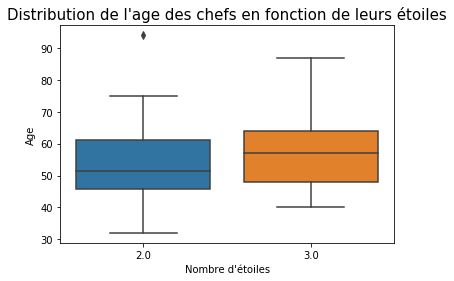

In [40]:
#graph 1
sns.boxplot(x='nb_star_chef',y='age',data=chef)
plt.xlabel("Nombre d'étoiles")
plt.ylabel("Age")
plt.title("Distribution de l'age des chefs en fonction de leurs étoiles", size=15)

On remarque une différence dans la distribution de l'age des chefs en fonction de leur nombre d'étoiles. En effet, les chefs 3 étoiles sont globalement plus agés que ceux 2 étoiles, le plus jeune des chefs 3 étoiles ayant 40 ans contre 32 pour le plus jeune 2 étoiles. De plus, on peut penser que cette différence d'age est sans doute plus importante, du au fait que seulement 48% des chefs 2 étoiles possèdent une page wikipédia alors que 100% des chefs 3 étoiles en ont une. Par conséquent, on peut supposer que l'abscence de page wikipédia est un signe jeunesse car celle-ci implique une popularité moins grande.

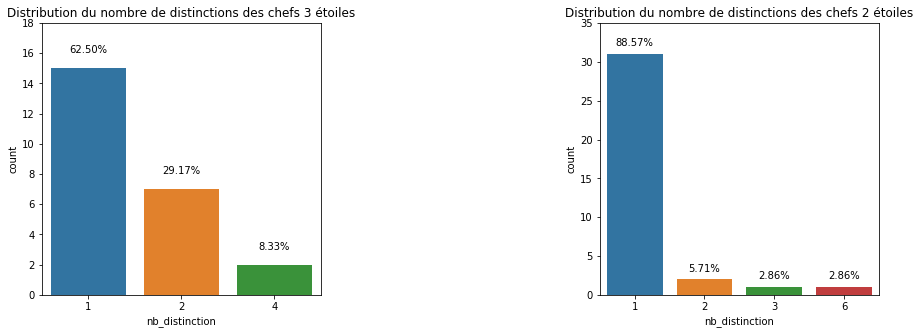

In [41]:
#graph 2
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
total3=len(chef.loc[((chef['nb_star_chef']==3) & (chef['age']<85)),'nb_distinction'])
ax3=sns.countplot(x='nb_distinction',data=chef.loc[((chef['nb_star_chef']==3) & (chef['age']<85)),:])
for p in ax3.patches:
    height = p.get_height()
    ax3.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '{:1.2f}%'.format((height/total3)*100),
            ha="center")
ax3.set_title("Distribution du nombre de distinctions des chefs 3 étoiles")
ax3.set(ylim=(0, 18))
plt.subplot(1,2,2)
total2=len(chef.loc[((chef['nb_star_chef']==2) & (chef['age']<85)),'nb_distinction'])
ax2=sns.countplot(x='nb_distinction',data=chef.loc[((chef['nb_star_chef']==2) & (chef['age']<85)),:])
for p in ax2.patches:
    height = p.get_height()
    ax2.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '{:1.2f}%'.format((height/total2)*100),
            ha="center")
ax2.set_title("Distribution du nombre de distinctions des chefs 2 étoiles")
ax2.set(ylim=(0, 35))
plt.subplots_adjust(wspace = 1)
plt.show()

Par défaut, les chefs possèdent une distinction liée au fait d'être le chef d'un restaurant étoilé. Cependant, on distingue que les chefs des restaurants 3 étoiles possèdent plus régulièrement une seconde distinctinction, tel que par exemple, le titre de meilleur ouvrier de France.

Text(0.5, 1.0, 'Répartition des nationalités des chefs')

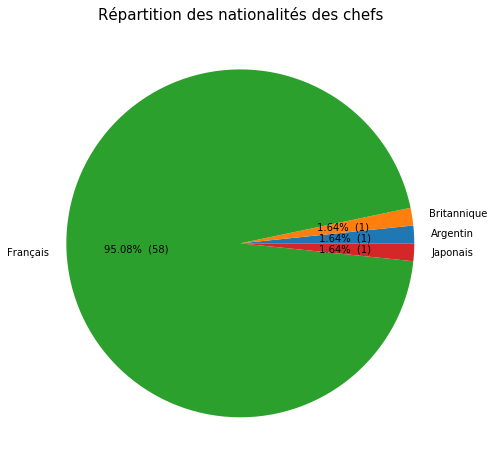

In [42]:
#graph 3

values=chef.groupby(['nationalité'])['nationalité'].count().values
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.figure(figsize=(12,8))
plt.pie(x=chef.groupby(['nationalité'])['nationalité'].count(), 
        labels=chef.groupby(['nationalité'])['nationalité'].count().index, autopct=make_autopct(values))
#plt.legend(loc='upper right')
plt.title("Répartition des nationalités des chefs", size=15)

On constate que mise à part quelques exeptions, la grande majorité des chefs doublement ou triplement étoilés en France sont français.

## Statistitques spaciales sur les restaurants

In [43]:
#drawing the restaurants position on france map
base=communes_borders.plot(figsize=(20,20))
gpdDf.plot(ax=base,color = 'red', alpha = 0.2)
plt.title("les localisations des restaurants sur la carte de la france")

NameError: name 'communes_borders' is not defined

On remarque qu'il y a une forte concentration de restaurants le long du littoral. De plus, 5 autres endroits se démarquent par leurs concentrations :
-Paris; Le long de la loire; Alsace ; Les alpes; le long du Rhone.
En fin de compte, les restaurants semblent se concentrer dnas des lieux à fort tourisme.

In [ ]:
dataf=restaurantCommuneDf[restaurantCommuneDf["Michelin Stars"]==3].groupby('departement').agg(["count"])['name']
cmap= pd.merge(left= communes_borders, right = dataf, on = "departement")
base= communes_borders.plot(figsize=(20,20))
cmap.plot(ax=base,column="count",cmap='viridis',legend=True,legend_kwds={
    'label': "la distribution des restaurants 3 étoiles"
})
plt.title("la distribution des restaurants possédant 3 étoiles par département")

On constate que Paris concentre le plus grand nombre de restaurants 3 étoiles.
En effet, les restaurants 3 étoiles se situent principalement à Paris et le long du litoral sud. Le reste des restaurants 3 étoiles se situent dans les aple et un se situe en Champagne. Les restaurants 3 étoiles se situent donc dans des lieux fortement touristiques.

In [ ]:
dataf=restaurantCommuneDf[restaurantCommuneDf["Michelin Stars"]==2].groupby('departement').agg(["count"])['name']
cmap_two_resto= pd.merge(left= communes_borders, right = dataf, on = "departement") 
base= communes_borders.plot(figsize=(20,20))
cmap_two_resto.plot(ax=base,column="count",cmap='viridis',legend=True,legend_kwds={
    'label': "la distribution des restaurants 2 étoiles"})
plt.title("la distribution des restaurants possédant 2 étoiles par département")

La localistaion des restaurants 2 étoiles est similaire à celle des restaurants 3 étoiles, avec néanmoins plus de lieux touristiques représentés telle que le long de la loire et l'alsace.

In [ ]:
dataf=restaurantCommuneDf[restaurantCommuneDf["Michelin Stars"]==1].groupby('departement').agg(["count"])['name']
cmap_one_resto= pd.merge(left= communes_borders, right = dataf, on = "departement") 
base= communes_borders.plot(figsize=(20,20))
cmap_one_resto.plot(ax=base,column="count",cmap='viridis',legend=True,legend_kwds={
    'label': "la distribution des restaurants 1 étoile"})
plt.title("la distribution des restaurants possédant 1 étoile par département")

Excepté Paris qui se distingue par son  grand nombre de restaurants 1 étoile, le reste de la répartition des ces restaurants est relativement homogène en France.

Conclusion: We notice that the number of restaurants decreases with the number of stars. This is predictable because of the fact that not all the resataurant have the same quality. In addition to that, Paris has always had the highest number of restaurants in each category. This in a way is an evidence because of it's attractiveness as a the capital of france as well as being one of the most beautifull city in the world

## Statistiques sur les restaurants

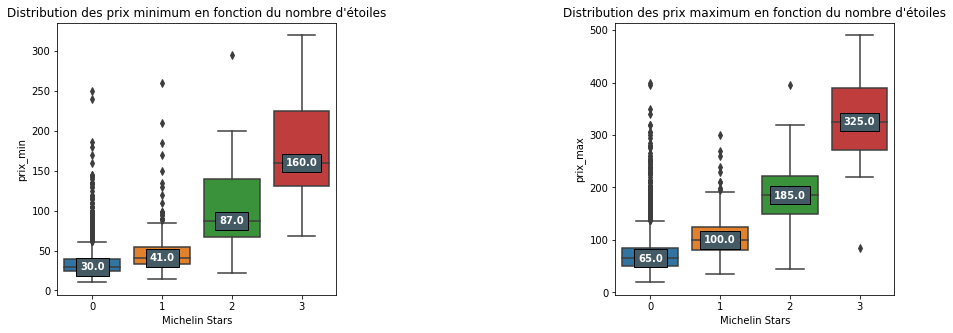

In [44]:
#graph 1

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
box_plot1=sns.boxplot(x='Michelin Stars',y='prix_min',data=df)
ax = box_plot1.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))
box_plot1.set_title("Distribution des prix minimum en fonction du nombre d'étoiles")

plt.subplot(1,2,2)
box_plot2=sns.boxplot(x='Michelin Stars',y='prix_max',data=df)
ax = box_plot2.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 

    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='bold', 
        size=10,
        color='white',
        bbox=dict(facecolor='#445A64'))
box_plot2.set_title("Distribution des prix maximum en fonction du nombre d'étoiles")
plt.subplots_adjust(wspace = 1)
plt.show()

On constate au vue de la médiane (statistique beaucoup plus adaptée que la moyenne dans ce cas-ci dû au grand nombre d'outliers dans les restaurants 0 et 1 étoile) que le montant maximum et minimum des menus augmente en fonction du nombre d'étoiles des restaurants. La moitié des restaurants non étoilés propose un menu le plus chère à un prix inférieur à 65 euros contre 325 euros pour les restaurants 3 étoiles.

-0.4
0
1582
0.6
0
698
1.6
0
146
2.6
0
120
3.6
0
99
4.6
0
48
5.6
0
41
6.6
0
40
7.6
0
37
8.6
0
37
-0.4
0
173
0.6
0
52
1.6
0
13
2.6
0
10
3.6
0
5
4.6
0
4
5.6
0
4
6.6
0
3
7.6
0
2
8.6
0
2
-0.4
0
20
0.6
0
15
1.6
0
3
2.6
0
1
-0.4
0
17
0.6
0
7
1.6
0
3
2.6
0
2
3.6
0
1


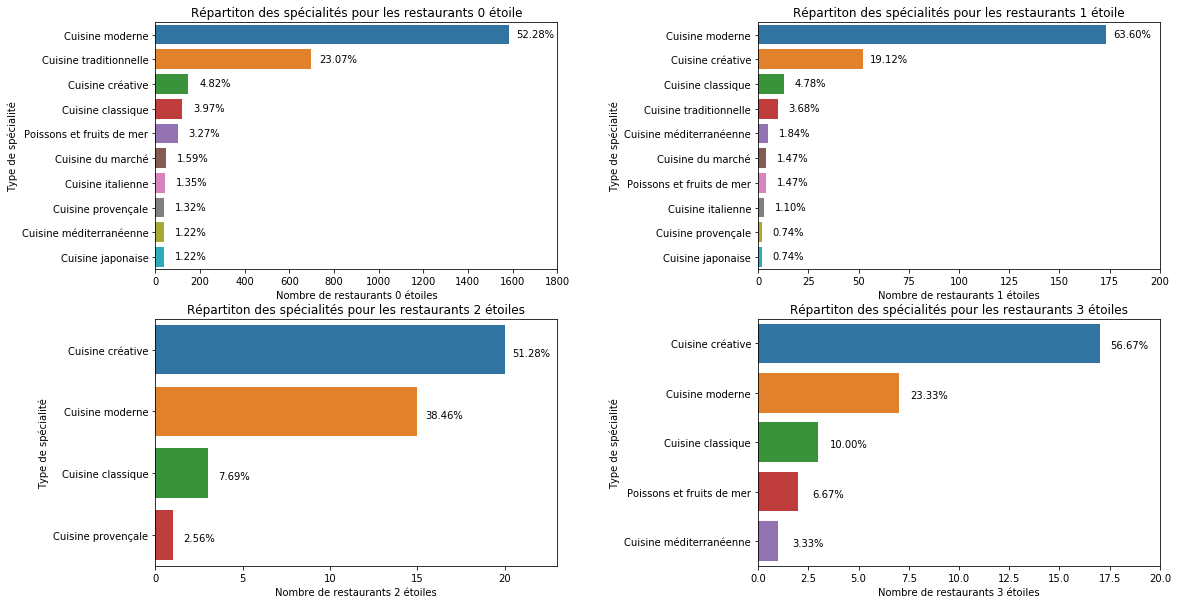

In [6]:
#graph 2

def special(nb_etoile,indice,xlim,ecart):
    dfe=df.loc[((df['Michelin Stars']==nb_etoile) & (df['specialite_1'] != ''))]
    total =len(dfe)

    ax=sns.countplot(y='specialite_1',data=dfe, order=dfe['specialite_1'].value_counts().iloc[:indice].index)
    for p in ax.patches:
        height = p.get_height()
        print(p.get_y())
        print(p.get_x())
        print(p.get_width())
        ax.text(p.get_width()+ecart,
                p.get_y()+0.5,
                '{:1.2f}%'.format((p.get_width()/total)*100),
                ha="center")
    ax.set(xlim=(0,xlim))
    ax.set_ylabel('Type de spécialité')
    ax.set_xlabel('Nombre de restaurants {etoile} étoiles'.format(etoile=nb_etoile))
    return ax

plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
ax0=special(0,10,1800,120)
ax0.set(title="Répartiton des spécialités pour les restaurants 0 étoile")

plt.subplot(2,2,2)
ax1=special(1,10,200,13)
ax1.set(title="Répartiton des spécialités pour les restaurants 1 étoile")

plt.subplot(2,2,3)
ax2=special(2,4,23,1.5)
ax2.set(title="Répartiton des spécialités pour les restaurants 2 étoiles")

plt.subplot(2,2,4)
ax3=special(3,5,20,1.5)
ax3.set(title="Répartiton des spécialités pour les restaurants 3 étoiles")

plt.subplots_adjust(wspace = 0.5)
plt.show()

On remarque que la spécialité "cuisine moderne" est la spécialité tous étoiles confondues à la différence de la spécialité "cuisine créative" dont la part augmente avec le nombre d'étoiles. De plus, on trouve une grande variété de spécialités sur les restaurants 0 et 1 étoiles, qu'on ne retrouve pas sur les 2 et 3 étoiles. 

## ----------------------------------------------------------------------------------------------------------------------------------

# Modélisation

In [48]:
df['Michelin Stars']=df['Michelin Stars'].astype('category')
#on selectionne nos variables d'interet
var_int_num=['prix_max','prix_min','latitude','longitude']
var_int_cat=['specialite_1'] 
var_int=var_int_num + var_int_cat

In [49]:
#on embellie la table en vue de la modélisation
#voir combien de nan, pour voir si on drop ou pas les rows avec nan
index_nan = df.index[df.loc[:,'specialite_1'].isnull()]
print(df.loc[index_nan,:].groupby('Michelin Stars')['Michelin Stars'].count())
#il y a 3 nan, on décide de les supprimer
df.drop(index_nan,axis=0, inplace=True)

#il n'y a pas de nan dans les prix
index_nan_prix = df.index[(df.loc[:,'prix_max'].isnull())&(df.loc[:,'prix_min'].isnull())]
df.loc[index_nan_prix,:].groupby('Michelin Stars')['Michelin Stars'].count()

Michelin Stars
0    3
1    0
2    0
3    0
Name: Michelin Stars, dtype: int64


Michelin Stars
0    0
1    0
2    0
3    0
Name: Michelin Stars, dtype: int64

### On supprime les outliers déterminés par les boxplots des prix

In [50]:
Q1 = df.groupby('Michelin Stars')['prix_min'].quantile(0.25)
Q3 = df.groupby('Michelin Stars')['prix_min'].quantile(0.75)
IQR = Q3 - Q1
index_min=[]
for i in range(0,4) :
    filtre = (df.loc[df['Michelin Stars']==i,'prix_min'] >= Q1.values[i] - 1.5 * IQR.values[i]) & (df.loc[df['Michelin Stars']==i,'prix_min'] <= Q3.values[i] + 1.5 *IQR.values[i])
    ind=df.loc[df['Michelin Stars']==i].index[filtre]
    index_min=index_min+ (ind.values.tolist())

In [51]:
Q1 = df.groupby('Michelin Stars')['prix_max'].quantile(0.25)
Q3 = df.groupby('Michelin Stars')['prix_max'].quantile(0.75)
IQR = Q3 - Q1
index_max=[]
for i in range(0,4) :
    filtre = (df.loc[df['Michelin Stars']==i,'prix_max'] >= Q1.values[i] - 1.5 * IQR.values[i]) & (df.loc[df['Michelin Stars']==i,'prix_max'] <= Q3.values[i] + 1.5 *IQR.values[i])
    ind=df.loc[df['Michelin Stars']==i].index[filtre]
    index_max=index_max+ (ind.values.tolist())

In [52]:
#on recupere les index present dans les 2 listes
index=[]
for i in index_min:
    if i in index_max :
        index.append(i)
df.loc[index,:].groupby('Michelin Stars')['Michelin Stars'].count()


Michelin Stars
0    2705
1     249
2      38
3      29
Name: Michelin Stars, dtype: int64

In [53]:
df_clean=df.loc[index,:]
len(df_clean.index[df_clean.loc[:,'specialite_1'].isnull()])

0

il n'y a pas de specialité_1 manquante. Cependant, un certain nombre de spécialités sont sous réprésentées, ce qui pose un problème pour le OneHotEncoder, on décide donc de renommer ces spécialitités en 'autre'.

In [54]:
speci_ssr=df_clean.groupby('specialite_1')['specialite_1'].count().sort_values()[df_clean.groupby('specialite_1')['specialite_1'].count().sort_values()<=5].index.values.tolist()
df_clean.replace(to_replace=tuple(speci_ssr), value='autre', inplace=True)
df_clean.groupby('specialite_1')['specialite_1'].count().sort_values().head(20)

specialite_1
Cuisine Fusion                 6
Cuisine bretonne               7
Cuisine chinoise               7
Cuisine thaïlandaise           7
Spécialités de Viandes         7
Cuisine corse                  8
Cuisine lyonnaise              9
Cuisine du terroir            19
Cuisine alsacienne            20
Cuisine régionale             23
Cuisine japonaise             26
Cuisine méditerranéenne       34
Cuisine provençale            35
Cuisine italienne             39
Cuisine du marché             52
autre                         58
Poissons et fruits de mer     92
Cuisine classique            107
Cuisine créative             170
Cuisine traditionnelle       689
Name: specialite_1, dtype: int64

## Modélisation

In [55]:
X_train, X_test, Y_train, Y_test= train_test_split(df_clean[var_int], df_clean['Michelin Stars'], test_size=0.2,random_state=10)

### On teste avec un linearSVC

0.915702479338843


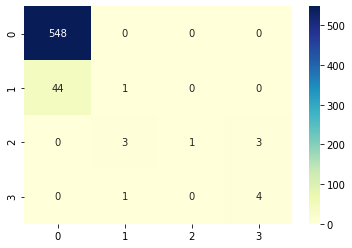

In [56]:
pre=make_column_transformer((OneHotEncoder(),var_int_cat),
                           (StandardScaler(),var_int_num))

model=make_pipeline(pre,LinearSVC(max_iter=100000,random_state=0))

model.fit(X_train, Y_train)
print(model.score(X_test,Y_test))

mat=confusion_matrix(Y_test, model.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")


Le linearSVC obtient un score de 0.9157, ce score est relativement élévé car les 0 étoiles sont bien prédits, or ceux-ci représentent la majorité des restaurants. Cependant, on remarque que mise à part les 3* les autres sont mal prédits.

### On teste avec un KNeighborsClassifier

In [57]:

pre=make_column_transformer((OneHotEncoder(),var_int_cat),
                           (StandardScaler(),var_int_num))

model=make_pipeline(pre,KNeighborsClassifier())

#model.fit(X_train, Y_train)
#model.score(X_test,Y_test)


cv=StratifiedKFold(5)
param={'kneighborsclassifier__metric':['manhattan','minkowski'],'kneighborsclassifier__n_neighbors':np.arange(1,20)}

grid1=GridSearchCV(model,param_grid=param,cv=cv)
grid1.fit(X_train, Y_train)
score1=grid1.best_score_
param1=grid1.best_params_
esti1=grid1.best_estimator_

{'kneighborsclassifier__metric': 'minkowski', 'kneighborsclassifier__n_neighbors': 9}
0.9223140495867769


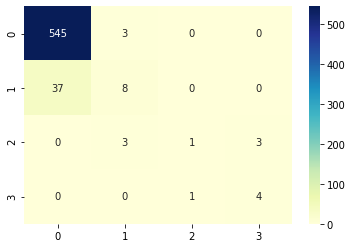

In [58]:
print(param1)
esti1.fit(X_train,Y_train)
print(esti1.score(X_test,Y_test))

mat=confusion_matrix(Y_test, esti1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")

Dans un premier temps on détermine les meilleurs hyperparamètres du modèle, en testant la qualité d'un modèle par validation croisée de type StratifiedKFold, méthode plus adapté qu'un KFold classique de par le déséquilibre de nos classes. Le KNeighborsClassifier obtient un score de 0.9223, ce score est relativement élévé car les 0 étoiles sont bien prédits, or ceux-ci représentent la majorité des restaurants. Cependant, on remarque que mise à part les 3* les autres sont plutot mal prédits malgré une amélioration pour les restaurants 1*.

### On teste avec SVC non linéaire 

In [59]:

pre=make_column_transformer((OneHotEncoder(),var_int_cat),
                           (StandardScaler(),var_int_num))

model=make_pipeline(pre,SVC(max_iter=100000,random_state=0))

#model.fit(X_train, Y_train)
#model.score(X_test,Y_test)


cv=StratifiedKFold(5)
param={'svc__kernel':['linear', 'poly', 'rbf', 'sigmoid'],'svc__degree':np.arange(1,10)}

grid1=GridSearchCV(model,param_grid=param,cv=cv)
grid1.fit(X_train, Y_train)
score1=grid1.best_score_
param1=grid1.best_params_
esti1=grid1.best_estimator_

{'svc__degree': 2, 'svc__kernel': 'poly'}
0.9239669421487603


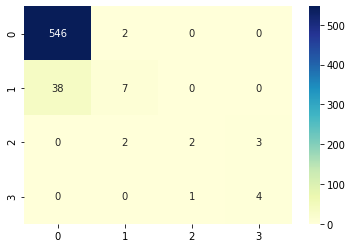

In [60]:
print(param1)
esti1.fit(X_train,Y_train)
print(esti1.score(X_test,Y_test))

mat=confusion_matrix(Y_test, esti1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")

Dans un premier temps on détermine les meilleurs hyperparamètres du modèle, en testant la qualité d'un modèle par validation croisée de type StratifiedKFold. Le SVC obtient un score de 0.9239, ce score est là encore relativement élévé car les 0 étoiles sont bien prédits, or ceux-ci représentent la majorité des restaurants. Cependant, on remarque que mise à part les 3* les autres sont plutot mal prédits malgré une amélioration pour les restaurants 1* et une très légére amélioration pour les 2*.

### Méthode de gradient boosting

In [61]:

pre=make_column_transformer((OneHotEncoder(),var_int_cat),
                           (StandardScaler(),var_int_num))

model=make_pipeline(pre,GradientBoostingClassifier(random_state=0))

#model.fit(X_train, Y_train)
#model.score(X_test,Y_test)


cv=StratifiedKFold(5)
param={'gradientboostingclassifier__n_estimators':np.arange(1,100,5)}

grid1=GridSearchCV(model,param_grid=param,cv=cv)
grid1.fit(X_train, Y_train)
score1=grid1.best_score_
param1=grid1.best_params_
esti1=grid1.best_estimator_

{'gradientboostingclassifier__n_estimators': 21}
0.9289256198347108


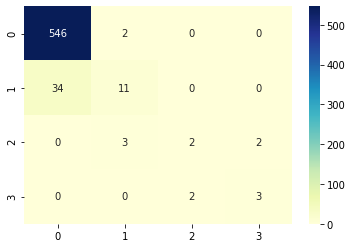

In [62]:
print(param1)
esti1.fit(X_train,Y_train)
print(esti1.score(X_test,Y_test))

mat=confusion_matrix(Y_test, esti1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")

Dans un premier temps on détermine les meilleurs hyperparamètres du modèle, en testant la qualité d'un modèle par validation croisée de type StratifiedKFold. Le GradientBoostingClassifier obtient un score de 0.9289, ce score est relativement élévé car les 0 étoiles sont bien prédits. Cependant, on remarque que les autres restaurants ne sont pas particulièrement bien prédits, même si ce modèle nous donne un meilleur résultat pour les restaurants 1 étoiles.

### Méthode de Random Forest

In [65]:
pre=make_column_transformer((OneHotEncoder(),var_int_cat),
                           (StandardScaler(),var_int_num))

model=make_pipeline(pre,RandomForestClassifier(random_state=0))

#model.fit(X_train, Y_train)
#model.score(X_test,Y_test)


cv=StratifiedKFold(5)
param={'randomforestclassifier__n_estimators':np.arange(1,160,10)}

grid1=GridSearchCV(model,param_grid=param,cv=cv)
grid1.fit(X_train, Y_train)
score1=grid1.best_score_
param1=grid1.best_params_
esti1=grid1.best_estimator_

{'randomforestclassifier__n_estimators': 141}
0.9305785123966942


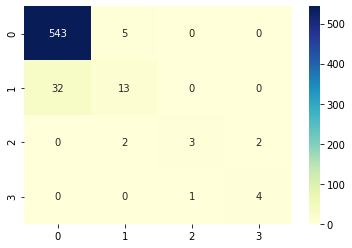

In [66]:
print(param1)
esti1.fit(X_train,Y_train)
print(esti1.score(X_test,Y_test))

mat=confusion_matrix(Y_test, esti1.predict(X_test))
sns.heatmap(mat,annot=True, fmt="d",cmap="YlGnBu")

Dans un premier temps on détermine les meilleurs hyperparamètres du modèle, en testant la qualité d'un modèle par validation croisée de type StratifiedKFold. Le RandomForestClassifier obtient un score de 0.9306, ce score est relativement élévé car les 0 étoiles sont bien prédits. Cependant, on remarque que les autres restaurants ne sont pas particulièrement bien prédits, même si ce modèle nous donne un meilleur résultat pour les restaurants 1 étoiles. Il obtient néanmoins un score très légérement plus élévé que la méthode de boosting.

### Conclusion modélisation

On constate que nos modèles donnent des résultats moyens, malgré un score relativement élévé de bonnes prédictions dû au gros nombre de restaurants 0 étoile bien prédits. Cependant, le modèles ont plus de difficultés sur les restaurants étoilés, principalement les 1 étoile. En effet, on a remarqué précédement, que les fourchettes de prix des restaurants se différenciant par une étoile en plus ou en moins se chevauchent régulièrement. Celà explique les mauvaises prédictions des restaurants à une catégories près. De plus, on a remarqué qu'un certain nombre de spécialités ne se retrouve que parmi les restaurants 0 et 1 étoiles, ce qui explique en partie le grands nombre de restaurants 1* prédit en 0* et l'absence de prédictions de restaurants 1* en restaurants 2*.